# Carga de librerías y definición de variables de ambiente

In [1]:
import rho_data_eng as eng
import pandas as pd
import numpy as np
import os


pd.set_option('display.max_columns', 500)

ds_path = os.getcwd()[:-len('notebooks')] + 'Data/Data Science/'
cars_path = os.getcwd()[:-len('notebooks')] + 'Data/Used Cars/'


ds_files = [x for x in os.listdir(ds_path) if 'train' in x]
cars_files = [x for x in os.listdir(cars_path) if 'unclean' in x]

print(ds_files)
print(cars_files)

['aug_train.csv']
['unclean cclass.csv', 'unclean focus.csv']


# Carga de Datos

Cargaremos los de CClass y Ciencia de Datos, y realizaremos el procesamiento para algunas variables.

In [2]:
cclass = pd.read_csv(cars_path + cars_files[0])
ds = pd.read_csv(ds_path + ds_files[0])

## Revisión de Missings:

In [3]:
eng.missing_zero_values_table(cclass)

Your selected dataframe has 11 columns and 4006 Rows.
There are 11 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
fuel type,0,2677,66.8,2677,66.8,object
mileage,0,198,4.9,198,4.9,object
fuel type2,0,198,4.9,198,4.9,object
engine size2,0,198,4.9,198,4.9,object
engine size,0,164,4.1,164,4.1,object
mileage2,0,116,2.9,116,2.9,object
year,0,102,2.5,102,2.5,float64
model,0,99,2.5,99,2.5,object
price,0,99,2.5,99,2.5,object
transmission,0,99,2.5,99,2.5,object


In [4]:
eng.missing_zero_values_table(ds)

Your selected dataframe has 14 columns and 19158 Rows.
There are 8 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
company_type,0,6140,32.0,6140,32.0,object
company_size,0,5938,31.0,5938,31.0,object
gender,0,4508,23.5,4508,23.5,object
major_discipline,0,2813,14.7,2813,14.7,object
education_level,0,460,2.4,460,2.4,object
last_new_job,0,423,2.2,423,2.2,object
enrolled_university,0,386,2.0,386,2.0,object
experience,0,65,0.3,65,0.3,object


## Tratamiento de valores ausentes:

* 1. Omisión
* 2. Imputación
    * Utilizando Media/Mediana
    * Utilizando Moda/Valor constante
    * KNN
    * Regresión Estocástica
* 3. KS y Chi-square

## 1. Omisión

La Omisión la realizaremos para aquellas columnas que tengan únicamente un porcentaje menor al 5% de datos reportados como ausentes. 

* Por ejemplo: 
    * Data Science education_level
    * enrolled_university
    * experience

In [5]:
aux = (ds.loc[(ds['education_level'].isna() == False) &
              (ds['enrolled_university'].isna() == False) &
              (ds['experience'].isna() == False)
             ].copy())

eng.missing_zero_values_table(aux)

Your selected dataframe has 14 columns and 18360 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
company_type,0,5659,30.8,5659,30.8,object
company_size,0,5470,29.8,5470,29.8,object
gender,0,4148,22.6,4148,22.6,object
major_discipline,0,2290,12.5,2290,12.5,object
last_new_job,0,346,1.9,346,1.9,object


In [6]:
# Omisión
lost_info = 100*(1 - len(aux)/len(ds))

print(f'Información perdida = {lost_info}')

Información perdida = 4.165361728781713


In [7]:
len(ds) - len(aux)

798

Realmente podemos apreciar que en efecto, no perdimos gran cantidad de información. 

## 2. Imputación

### Utilizando Media/Mediana

La imputación a través de la media/mediana, la haremos para valores continuos, en este caso, utilizaremos scikit-learn, y las variables serán las siguientes:

* mileage
* engine size2

Del dataset de cclass

In [8]:
# Librerías

from sklearn.impute import SimpleImputer

In [9]:
cclass.head(7)

,model,year,price,transmission,mileage,fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,C Class,2020.0,"£30,495",Automatic,NaN,Diesel,2,"1,200",NaN,NaN,/ad/25017331
1,C Class,2020.0,"£29,989",Automatic,NaN,Petrol,1.5,"1,000",NaN,NaN,/ad/25043746
2,C Class,2020.0,"£37,899",Automatic,NaN,Diesel,2,500,NaN,NaN,/ad/25142894
3,C Class,2019.0,"£30,399",Automatic,NaN,Diesel,2,"5,000",NaN,NaN,/ad/24942816
4,C Class,2019.0,"£29,899",Automatic,NaN,Diesel,2,"4,500",NaN,NaN,/ad/24913660
5,C Class,2020.0,"£30,999",Automatic,NaN,Diesel,2,"1,000",NaN,NaN,/ad/25059312
6,C Class,2020.0,"£35,999",Automatic,NaN,Diesel,2,500,NaN,NaN,/ad/25418851


In [10]:
SimpleImputer?

In [11]:
float(' 2,3 00 '.replace(',', '').replace(' ', ''))

2300.0

In [12]:
#Columns
cols = ['mileage', 'engine size2']

# Instanciamos la clase:
impmean = SimpleImputer(missing_values=np.nan, strategy='mean')
impmedian = SimpleImputer(missing_values=np.nan, strategy='median')

def clean(x):
    
    if type(x) == str:
        if x =='Unknown': x = np.nan
        else: x = float(x.replace(',', '').replace(' ', ''))
    else: x = float(x)
    
    return(x)

aux = cclass[cols].copy()
aux[cols[0] + '_imp_mean'] = impmean.fit_transform(np.array(aux[cols[0]].map(lambda x:clean(x))).reshape(-1,1))
aux[cols[1] + '_imp_median'] = impmedian.fit_transform(np.array(aux[cols[1]].map(lambda x:clean(x))).reshape(-1,1))
aux.head(1)

,mileage,engine size2,mileage_imp_mean,engine size2_imp_median
0,NaN,NaN,22126.070434,2.0


### Utilizando Moda/Valor fijo

La imputación a través de la Moda/Valor Fijo, la haremos para valores discretos, en este caso, utilizaremos scikit-learn, y las variables serán las siguientes:

* gender
* major_discipline

Del dataset de ds

In [13]:
# Columnas
cols = ['gender', 'major_discipline']

modeimputer = SimpleImputer(missing_values='nan', strategy='most_frequent')
fxvalimputer = SimpleImputer(missing_values='nan', strategy='constant', fill_value = 'Other')

aux1 = ds[cols].copy()
aux1[cols[0] + '_imp_mode'] = fxvalimputer.fit_transform(np.array(aux1[cols[0]].astype(str)).reshape(-1,1))
aux1[cols[1] + '_imp_fixed_value'] = modeimputer.fit_transform(np.array(aux1[cols[1]].astype(str)).reshape(-1,1))
aux1.head(1)

,gender,major_discipline,gender_imp_mode,major_discipline_imp_fixed_value
0,Male,STEM,Male,STEM


In [14]:
len(aux1)

19158

In [15]:
np.array(aux1[cols[0]].astype(str))[0]

'Male'

In [16]:
np.array(aux1[cols[0]].astype(str)).reshape(-1,1)[0]

array(['Male'], dtype=object)

In [17]:
aux1['gender_imp_mode'].value_counts(dropna=False)

Male      13221
Other      4699
Female     1238
Name: gender_imp_mode, dtype: int64

In [18]:
aux1['gender'].value_counts(dropna=False)

Male      13221
NaN        4508
Female     1238
Other       191
Name: gender, dtype: int64

In [19]:
aux1['major_discipline'].value_counts(dropna=False)

STEM               14492
NaN                 2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [20]:
aux1['major_discipline_imp_fixed_value'].value_counts(dropna=False)

STEM               17305
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline_imp_fixed_value, dtype: int64

### KNN

Imputaremos valores continuos, volveremos a utilizar las siguiente variable:

* year

Del dataset de cclass

In [21]:
from sklearn.impute import KNNImputer

In [22]:
KNNImputer?

In [23]:
cclass.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuel type',
       'engine size', 'mileage2', 'fuel type2', 'engine size2', 'reference'],
      dtype='object')

In [24]:
# Columnas
cols = ['mileage', 'engine size2', 'year']
aux2 = cclass[cols].copy()
aux2['mileage'] = aux2['mileage'].apply(lambda x:clean(x))
aux2['engine size2'] = aux2['engine size2'].apply(lambda x:clean(x))
aux2

,mileage,engine size2,year
0,NaN,NaN,2020.0
1,NaN,NaN,2020.0
2,NaN,NaN,2020.0
3,NaN,NaN,2019.0
4,NaN,NaN,2019.0
...,...,...,...
4001,31357.0,1.598,2017.0
4002,28248.0,2.143,2018.0
4003,48055.0,2.143,2014.0
4004,49865.0,2.143,2014.0


In [25]:
kimp.fit_transform?

Object `kimp.fit_transform` not found.


In [26]:
kimp = KNNImputer(n_neighbors=7, add_indicator=True)
columns = [c +'_imp' for c in aux2.columns] + [c +'_ind' for c in aux2.columns]
pd.DataFrame(kimp.fit_transform(np.array(aux2)), columns = columns)

,mileage_imp,engine size2_imp,year_imp,mileage_ind,engine size2_ind,year_ind
0,1748.857143,2.071429,2020.0,1.0,1.0,0.0
1,1748.857143,2.071429,2020.0,1.0,1.0,0.0
2,1748.857143,2.071429,2020.0,1.0,1.0,0.0
3,7034.714286,2.000000,2019.0,1.0,1.0,0.0
4,7034.714286,2.000000,2019.0,1.0,1.0,0.0
...,...,...,...,...,...,...
4001,31357.000000,1.598000,2017.0,0.0,0.0,0.0
4002,28248.000000,2.143000,2018.0,0.0,0.0,0.0
4003,48055.000000,2.143000,2014.0,0.0,0.0,0.0
4004,49865.000000,2.143000,2014.0,0.0,0.0,0.0


### Regresión estocástica

Imputaremos valores continuos, volveremos a utilizar las siguiente variable:

* mileage

Del dataset de cclass

In [27]:
cclass.head(3)

,model,year,price,transmission,mileage,fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,C Class,2020.0,"£30,495",Automatic,NaN,Diesel,2,"1,200",NaN,NaN,/ad/25017331
1,C Class,2020.0,"£29,989",Automatic,NaN,Petrol,1.5,"1,000",NaN,NaN,/ad/25043746
2,C Class,2020.0,"£37,899",Automatic,NaN,Diesel,2,500,NaN,NaN,/ad/25142894


In [28]:
aux3 = cclass[['year', 'price', 'mileage']].copy() #creación del df
pred = ['year', 'price'] #Definición de variables predictoras
tar = 'mileage' #Definición de variable objetivo
aux3['mileage'] = aux3['mileage'].map(lambda x:clean(x)) #Limpieza
aux3

,year,price,mileage
0,2020.0,"£30,495",NaN
1,2020.0,"£29,989",NaN
2,2020.0,"£37,899",NaN
3,2019.0,"£30,399",NaN
4,2019.0,"£29,899",NaN
...,...,...,...
4001,2017.0,"£14,700",31357.0
4002,2018.0,"£18,500",28248.0
4003,2014.0,"£11,900",48055.0
4004,2014.0,"£11,300",49865.0


In [29]:
# Revisión de Missings en las variables predictoras 

#para fines de esta situación omitiremos esos missings.

eng.missing_zero_values_table(aux3.sort_values(by = 'year'))

Your selected dataframe has 3 columns and 4006 Rows.
There are 3 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
mileage,0,201,5.0,201,5.0,float64
year,0,102,2.5,102,2.5,float64
price,0,99,2.5,99,2.5,object


In [30]:
import re
re.sub("[^A-Za-z0-9]", "", 'Aj£11,300')

'Aj11300'

In [31]:
''.join(list(filter(str.isdigit, '£Hol#&a11,300')))

'11300'

In [32]:
numeric_filter = filter(str.isdigit, '£11,300')
numeric_string = "".join(numeric_filter)
numeric_string

'11300'

In [33]:
def clean(x):
    
    if type(x) == str:
        if x =='Unknown': x = np.nan
        else: x = float(x.replace(',', '').replace(' ', ''))
    else: x = float(x)
    
    return(x)

def clean2(x):
    import re
    
    
    if type(x) == str:
        x = re.sub("[^0-9]", "", x)
        return(x)
    else:
        return(x)

In [34]:
aux3['price'] = aux3['price'].apply(lambda x:clean2(x))
aux3['mileage'] = aux3['mileage'].apply(lambda x:clean(x))

In [35]:
aux3.reset_index(drop = True, inplace = True)

In [36]:
# Vamos a utilizar KNN para imputar los valores de las variables predictoras.

ki = KNNImputer(add_indicator=True)
columns = [c +'_imp' for c in aux3.columns] + [c +'_ind' for c in aux3.columns]
aux3_imp = pd.DataFrame(ki.fit_transform(np.array(aux3)), columns = columns)
aux3 = aux3.merge(aux3_imp, how = 'inner', left_index = True, right_index = True)

In [37]:
aux3

,year,price,mileage,year_imp,price_imp,mileage_imp,year_ind,price_ind,mileage_ind
0,2020.0,30495,NaN,2020.0,30495.0,7585.0,0.0,0.0,1.0
1,2020.0,29989,NaN,2020.0,29989.0,5970.6,0.0,0.0,1.0
2,2020.0,37899,NaN,2020.0,37899.0,8219.2,0.0,0.0,1.0
3,2019.0,30399,NaN,2019.0,30399.0,6758.2,0.0,0.0,1.0
4,2019.0,29899,NaN,2019.0,29899.0,7028.6,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
4001,2017.0,14700,31357.0,2017.0,14700.0,31357.0,0.0,0.0,0.0
4002,2018.0,18500,28248.0,2018.0,18500.0,28248.0,0.0,0.0,0.0
4003,2014.0,11900,48055.0,2014.0,11900.0,48055.0,0.0,0.0,0.0
4004,2014.0,11300,49865.0,2014.0,11300.0,49865.0,0.0,0.0,0.0


In [38]:
train = aux3[['year_imp', 'price_imp', 'year_ind', 'price_ind', 'mileage']].loc[aux3['mileage'].isna() == False].copy()
prediction = aux3[['year_imp', 'price_imp', 'year_ind', 'price_ind', 'mileage']].loc[aux3['mileage'].isna() == True].copy()

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
train.reset_index(drop = True, inplace = True)

In [41]:
prediction.reset_index(drop = True, inplace = True)

In [42]:
# Regresión Lineal
pred = ['year_imp', 'price_imp', 'year_ind', 'price_ind']
X = train[pred]
y = train[tar]
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [43]:
lr.predict(prediction[pred]).reshape(-1,1)

array([[  1304.84424719],
       [  1665.21252852],
       [ -3968.21258082],
       [  7466.34313789],
       [  7822.43827755],
       [   945.90034642],
       [ -2615.05105013],
       [  2060.10672765],
       [  8469.81924144],
       [  8469.81924144],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 21264.42797906],
       [ 212

In [44]:
prediction['linear regression'] = lr.predict(prediction[pred])

In [45]:
prediction['linear regression'].describe(percentiles = [i/10 for i in range(10)])

count       201.000000
mean      26193.924292
std       18575.979258
min      -11859.993066
0%       -11859.993066
10%        7822.438278
20%       21264.427979
30%       21264.427979
40%       21264.427979
50%       21264.427979
60%       21264.427979
70%       25088.036597
80%       37424.937400
90%       44942.446582
max      125327.891870
Name: linear regression, dtype: float64

In [46]:
def isnegative(x, val):
    if x < 0:
        return(val)
    else:
        return(x)

In [47]:
n = prediction['linear regression'].loc[prediction['linear regression']>=0].min()

In [48]:
prediction['linear_regression_abs'] = prediction['linear regression'].map(lambda x:abs(x))
prediction['linear_regression_val'] = prediction['linear regression'].map(lambda x:isnegative(x, n))
aux_prediction_oms = prediction.loc[prediction['linear regression']>=0].copy()

In [49]:
prediction

,year_imp,price_imp,year_ind,price_ind,mileage,linear regression,linear_regression_abs,linear_regression_val
0,2020.0,30495.0,0.0,0.0,NaN,1304.844247,1304.844247,1304.844247
1,2020.0,29989.0,0.0,0.0,NaN,1665.212529,1665.212529,1665.212529
2,2020.0,37899.0,0.0,0.0,NaN,-3968.212581,3968.212581,247.241682
3,2019.0,30399.0,0.0,0.0,NaN,7466.343138,7466.343138,7466.343138
4,2019.0,29899.0,0.0,0.0,NaN,7822.438278,7822.438278,7822.438278
...,...,...,...,...,...,...,...,...
196,2020.0,34480.0,0.0,0.0,NaN,-1533.234016,1533.234016,247.241682
197,2016.0,14000.0,0.0,0.0,NaN,37424.937400,37424.937400,37424.937400
198,2015.0,12000.0,0.0,0.0,NaN,44942.446582,44942.446582,44942.446582
199,2017.0,22767.0,0.0,0.0,NaN,25088.036597,25088.036597,25088.036597


### Regresión estocástica

Para esto debemos calcular la varianza, entonces utilizaremos la predicción sobre el conjunto de entrenamiento y con base a eso, generaremos la distribución normal de los errores. 

In [55]:
y.values - lr.predict(X)

array([-13656.64534027,  21413.65519791,  48569.75033756, ...,
        -3051.7942343 ,  -1669.10840188,   6403.5575757 ])

In [56]:
import matplotlib.pyplot as plt

In [57]:
np.histogram(y.values - lr.predict(X))

(array([   2,    1,    0,   21,  782, 2632,  288,   55,   16,    8]),
 array([-117834.6775772 ,  -95781.04702212,  -73727.41646705,
         -51673.78591197,  -29620.15535689,   -7566.52480182,
          14487.10575326,   36540.73630834,   58594.36686341,
          80647.99741849,  102701.62797357]))

(array([2.000e+00, 1.000e+00, 0.000e+00, 2.100e+01, 7.820e+02, 2.632e+03,
        2.880e+02, 5.500e+01, 1.600e+01, 8.000e+00]),
 array([-117834.6775772 ,  -95781.04702212,  -73727.41646705,
         -51673.78591197,  -29620.15535689,   -7566.52480182,
          14487.10575326,   36540.73630834,   58594.36686341,
          80647.99741849,  102701.62797357]),
 <BarContainer object of 10 artists>)

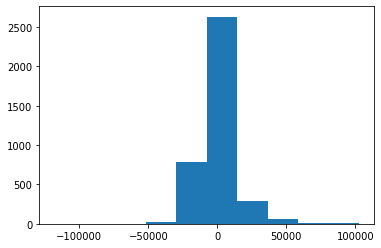

In [59]:
plt.hist(y.values - lr.predict(X), bins = 10)

In [67]:
# Cálculo de los residuales
residuals = y.values - lr.predict(X)

# Cálculo de la varianza
variance = residuals.var()

# Cálculo de la media
mean = residuals.mean()
print(mean)

# Generación de los errores. 
rnoise = np.random.normal(mean, np.sqrt(variance), len(prediction))

# Regresión estocástica.
prediction['Stochastic_regression'] = (prediction['linear regression']
                                      + rnoise)
prediction['Stochastic_regression_val'] = (prediction['linear_regression_val']
                                      + rnoise)
prediction['Stochastic_regression_abs'] = (prediction['linear_regression_abs']
                                      + rnoise)
prediction

-1.7192141298552224e-09


,year_imp,price_imp,year_ind,price_ind,mileage,linear regression,linear_regression_abs,linear_regression_val,Stochastic_regression,Stochastic_regression_val,Stochastic_regression_abs
0,2020.0,30495.0,0.0,0.0,NaN,1304.844247,1304.844247,1304.844247,23964.994273,23964.994273,23964.994273
1,2020.0,29989.0,0.0,0.0,NaN,1665.212529,1665.212529,1665.212529,-18282.132655,-18282.132655,-18282.132655
2,2020.0,37899.0,0.0,0.0,NaN,-3968.212581,3968.212581,247.241682,-12746.260236,-8530.805972,-4809.835074
3,2019.0,30399.0,0.0,0.0,NaN,7466.343138,7466.343138,7466.343138,33514.360815,33514.360815,33514.360815
4,2019.0,29899.0,0.0,0.0,NaN,7822.438278,7822.438278,7822.438278,-6008.860758,-6008.860758,-6008.860758
...,...,...,...,...,...,...,...,...,...,...,...
196,2020.0,34480.0,0.0,0.0,NaN,-1533.234016,1533.234016,247.241682,-9984.830626,-8204.354927,-6918.362594
197,2016.0,14000.0,0.0,0.0,NaN,37424.937400,37424.937400,37424.937400,31384.803534,31384.803534,31384.803534
198,2015.0,12000.0,0.0,0.0,NaN,44942.446582,44942.446582,44942.446582,40992.095743,40992.095743,40992.095743
199,2017.0,22767.0,0.0,0.0,NaN,25088.036597,25088.036597,25088.036597,28639.218937,28639.218937,28639.218937


In [69]:
rnoise_oms = np.random.normal(mean, np.sqrt(variance), len(aux_prediction_oms))

aux_prediction_oms['Stochastic regression'] = (aux_prediction_oms['linear regression']
                                              + rnoise_oms)
aux_prediction_oms

,year_imp,price_imp,year_ind,price_ind,mileage,linear regression,linear_regression_abs,linear_regression_val,Stochastic regression
0,2020.0,30495.0,0.0,0.0,NaN,1304.844247,1304.844247,1304.844247,-8918.776118
1,2020.0,29989.0,0.0,0.0,NaN,1665.212529,1665.212529,1665.212529,-3623.899730
3,2019.0,30399.0,0.0,0.0,NaN,7466.343138,7466.343138,7466.343138,-2669.388464
4,2019.0,29899.0,0.0,0.0,NaN,7822.438278,7822.438278,7822.438278,4554.240940
5,2020.0,30999.0,0.0,0.0,NaN,945.900346,945.900346,945.900346,-70.716109
...,...,...,...,...,...,...,...,...,...
195,2020.0,29980.0,0.0,0.0,NaN,1671.622241,1671.622241,1671.622241,-18302.806120
197,2016.0,14000.0,0.0,0.0,NaN,37424.937400,37424.937400,37424.937400,47658.593996
198,2015.0,12000.0,0.0,0.0,NaN,44942.446582,44942.446582,44942.446582,53128.615056
199,2017.0,22767.0,0.0,0.0,NaN,25088.036597,25088.036597,25088.036597,25225.443987


In [71]:
aux_prediction_oms.loc[aux_prediction_oms['Stochastic regression']<0].shape

(16, 9)

In [74]:
import plotly.graph_objects as go

prediction = prediction.sort_values(by = 'price_imp')

random_x = prediction['price_imp']
#random_y0 = prediction['mileage']
random_y1 = prediction['linear regression']
random_y2 = prediction['Stochastic_regression']

# Creamos los trazos
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='markers',
                    name='Linear'))
fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                    mode='markers',
                    name='Stochastic'))

fig.show()

In [75]:
def plot(df, x, y_values, sample = False, sample_size = .8, tipo = 'lines'):
    
    import plotly.graph_objects as go

    if sample:
        df = df.sample(frac = sample_size)
        
    df = df.sort_values(by = x)
    
    vals = dict()
    random_x = df[x]
    
    

    # Creamos los trazos
    fig = go.Figure()
    
    
    for y in y_values:
        
        fig.add_trace(go.Scatter(x=random_x, y=df[y],
                            mode=tipo,
                            name=y))

    return(fig.show())

In [78]:
plot(prediction, 'price_imp', ['linear regression', 'Stochastic_regression'], sample = True, sample_size = .2, tipo = 'markers')

In [79]:
plot(prediction, 'price_imp', ['linear regression', 'Stochastic_regression'], sample = True, sample_size = .2)

## KS y Chi-square

In [97]:
from scipy.stats import ks_2samp, chisquare

In [99]:
ks_2samp?

In [100]:
aux3

,year,price,mileage,year_imp,price_imp,mileage_imp,year_ind,price_ind,mileage_ind
0,2020.0,30495,NaN,2020.0,30495.0,7585.0,0.0,0.0,1.0
1,2020.0,29989,NaN,2020.0,29989.0,5970.6,0.0,0.0,1.0
2,2020.0,37899,NaN,2020.0,37899.0,8219.2,0.0,0.0,1.0
3,2019.0,30399,NaN,2019.0,30399.0,6758.2,0.0,0.0,1.0
4,2019.0,29899,NaN,2019.0,29899.0,7028.6,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
4001,2017.0,14700,31357.0,2017.0,14700.0,31357.0,0.0,0.0,0.0
4002,2018.0,18500,28248.0,2018.0,18500.0,28248.0,0.0,0.0,0.0
4003,2014.0,11900,48055.0,2014.0,11900.0,48055.0,0.0,0.0,0.0
4004,2014.0,11300,49865.0,2014.0,11300.0,49865.0,0.0,0.0,0.0


In [102]:
rsp1 = aux3['price_imp']
rsm1 = aux3['mileage_imp']
rsp2 = aux3['price_imp'].loc[aux3['price'].isna() == False]
rsm2 = aux3['mileage_imp'].loc[aux3['mileage'].isna() == False]

In [103]:
import random as rn
rn.randint(0,5)

0

In [106]:
ks_2samp([i for i in range(50)], [i+rn.randint(0,5) for i in range(-50, 0)]) # Distribuciones distintas

KstestResult(statistic=0.96, pvalue=9.812536491204155e-26)

In [107]:
ks_2samp([i for i in range(50)], [i for i in range(50)]) # Distribuciones iguales

KstestResult(statistic=0.0, pvalue=1.0)

In [108]:
# KS
ks_2samp(rsp1, rsp2)

KstestResult(statistic=0.013049085189722455, pvalue=0.882796852588368)

In [109]:
ks_2samp(rsm1, rsm2)

KstestResult(statistic=0.021390647274817078, pvalue=0.3273621400824941)

La prueba nos muestra el pvalue, si nosotros asginaramos un nivel de significancia $\alpha$ = .05, entonces requeriríamos que el pvalue fuese menor a ese .05. En este caso no se cumple, por lo que no podemos rechazar la hipótesis nula de que ambos provienen de una misma muestra aleatoria.

Por ende, dado que el pvalue nos reporta que no es menor que nuestro alpha, podemos no rechazar la hipótesis nula. 

In [110]:
val = prediction.copy()
val['Stochastic regression'] = val['Stochastic_regression']

In [111]:
# KS

ks_2samp(val['linear regression'], val['Stochastic regression'])

KstestResult(statistic=0.2537313432835821, pvalue=4.301751530917112e-06)

In [112]:
val.columns

Index(['year_imp', 'price_imp', 'year_ind', 'price_ind', 'mileage',
       'linear regression', 'linear_regression_abs', 'linear_regression_val',
       'Stochastic_regression', 'Stochastic_regression_val',
       'Stochastic_regression_abs', 'Stochastic regression'],
      dtype='object')

In [113]:
ks_2samp(val['linear regression'], val['linear_regression_val'])

KstestResult(statistic=0.04477611940298507, pvalue=0.9881281871806125)

In [114]:
ks_2samp(val['linear regression'], val['linear_regression_abs'])

KstestResult(statistic=0.04477611940298507, pvalue=0.9881281871806125)

In [115]:
ks_2samp(val['linear_regression_val'], val['linear_regression_abs'])

KstestResult(statistic=0.04477611940298507, pvalue=0.9881281871806125)

# Chi

In [116]:
chisquare?

In [117]:
aux1

,gender,major_discipline,gender_imp_mode,major_discipline_imp_fixed_value
0,Male,STEM,Male,STEM
1,Male,STEM,Male,STEM
2,NaN,STEM,Other,STEM
3,NaN,Business Degree,Other,Business Degree
4,Male,STEM,Male,STEM
...,...,...,...,...
19153,Male,Humanities,Male,Humanities
19154,Male,STEM,Male,STEM
19155,Male,STEM,Male,STEM
19156,Male,NaN,Male,STEM


In [122]:
# Chi

chisquare(f_obs = aux1['gender_imp_mode'].value_counts(True).sort_index().values,
          f_exp = aux1['gender'].value_counts(True).sort_index().values)

Power_divergenceResult(statistic=4.191527958736933, pvalue=0.12297625643366397)

In [123]:
aux1['gender'].value_counts(1, dropna = False)

Male      0.690103
NaN       0.235306
Female    0.064621
Other     0.009970
Name: gender, dtype: float64

In [124]:
aux1['gender_imp_mode'].value_counts(1, dropna = False)

Male      0.690103
Other     0.245276
Female    0.064621
Name: gender_imp_mode, dtype: float64

La prueba nos muestra el pvalue, si nosotros asginaramos un nivel de significancia $\alpha$ = .05, entonces requeriríamos que el pvalue fuese menor a ese .05. En este caso no se cumple, por lo que no podemos rechazar la hipótesis nula de que ambos provienen de una misma muestra aleatoria.

In [125]:
aux4 = pd.DataFrame(aux1['gender_imp_mode'].value_counts(True))
aux4['prueba'] = [.05, .90, .05]
aux4

,gender_imp_mode,prueba
Male,0.690103,0.05
Other,0.245276,0.90
Female,0.064621,0.05


In [126]:
chisquare(f_obs = aux4['gender_imp_mode'].values,
          f_exp = aux4['prueba'].values) # Distribuciones distintas

Power_divergenceResult(statistic=8.675213809859189, pvalue=0.013067763214084926)

Hay métodos que lo parametrizan:
* output = 1 - p-value
* output = p-value